In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

## Helper functions

In [2]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [3]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [4]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

In [22]:
def bland_altman_plot(Dm_data, AAA_data, structure, metric, *args, **kwargs):
    Dm_data     = np.asarray(Dm_data)
    AAA_data     = np.asarray(AAA_data)
    z_stat, p_val = wilcoxon(Dm_data, AAA_data)
    mean      = np.mean([Dm_data, AAA_data], axis=0)
    diff      = Dm_data - AAA_data                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    # plt.scatter(mean, diff, *args, **kwargs)
    plt.scatter(AAA_data, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('AAA Dose (Gy)')
    plt.ylabel('Dm - AAA Difference (Gy)')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

# Start analysis

In [25]:
HN_df = pd.read_csv('HN_df_clean_28_11.csv')  # read in the cleaned data
HN_df['Dm-AAA'] = HN_df['Dm'] - HN_df['AAA'] # get abs diff
HN_df['Dm-AAA_%'] = 100.0*(HN_df['Dm'] - HN_df['AAA'])/HN_df['AAA'] # get abs diff

Exclude Case5 which has 54 Gy prescription

In [26]:
to_exclude = ['Case5', 'Case7']  # has prescription of 54 Gy  
to_include = list(set(HN_df['Case'].unique()) - set(to_exclude))
HN_df = HN_df[HN_df['Case'].isin(to_include)]
HN_df['Case'].unique()

array(['Case1', 'Case2', 'Case3', 'Case4', 'Case6', 'Case8', 'Case9',
       'Case10'], dtype=object)

In [27]:
len(HN_df['Case'].unique())

8

In [28]:
HN_df['structure'].unique()

array(['PTV2', 'PTV1', 'Body', 'R Parotid', 'L Parotid', 'Brain Stem',
       'Spinal Cord', 'CTV65'], dtype=object)

In [29]:
HN_df.head()

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA_%
0,Case1,PTV2,D2%,65.392496,64.671451,-0.721045,-1.102642
1,Case1,PTV2,D5%,61.221910,60.574434,-0.647476,-1.057589
2,Case1,PTV2,D50%,56.935482,56.306392,-0.629090,-1.104918
3,Case1,PTV2,D95%,52.908380,53.783883,0.875503,1.654753
4,Case1,PTV2,D99%,38.261698,45.021250,6.759552,17.666628


Everything imported OK

## Get mean dose differences

In [31]:
mean_diff_table = HN_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA')
percent_diff_table = HN_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA_%') 

In [32]:
#metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']  # use limited subset
metrics_of_interest = mean_diff_table.columns                      # use all metrics
metrics_of_interest

Index(['D0.1CC', 'D1CC', 'D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'DHI', 'DMAX',
       'DRX', 'DSD', 'V12.5GY', 'V20GY', 'V30GY', 'V40GY', 'V50GY', 'V55GY',
       'V5GY'],
      dtype='object', name='metric')

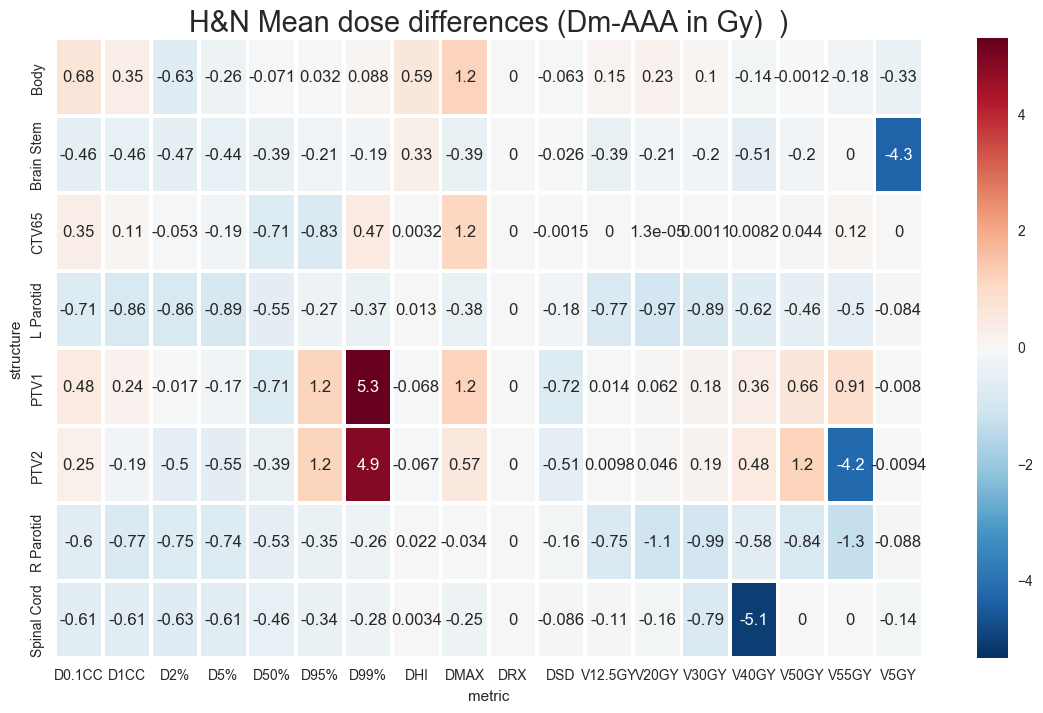

In [33]:
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table[metrics_of_interest], annot=True, linewidths=2.0, cbar=True)
ax1.set_title('H&N Mean dose differences (Dm-AAA in Gy)  )', size='xx-large')
plt.savefig('H&N Mean dose difference.png', dpi=200)

## Get wilcoxon p value of differences

In [34]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%',  'D0.1CC', 'DMAX']  # use limited subset, 'D99%',
#HN_df['structure'].unique()  # all structures
structures_of_interest = ['PTV1', 'PTV2', 'CTV65', 'L Parotid', 'R Parotid', 'Brain Stem', 'Spinal Cord']

In [35]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [36]:
d = HN_df  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [17]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [18]:
# Keep for plotting all p-vals

#confidence = 1.0
#plt.figure(figsize=(16, 8))
#ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
#ax2.set_title('HN p- value for mean dose differences (%) by structure and metric', size='xx-large')
#plt.savefig('HN p value for mean dose differences.png', dpi=500)

In [37]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]
percent_sub_diff_table = percent_diff_table[metrics_of_interest].loc[structures_of_interest]

0.19157269776634042


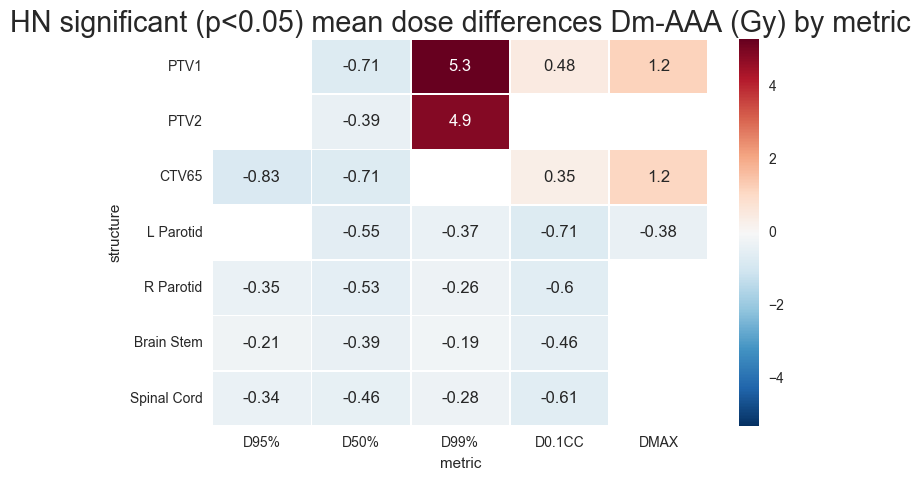

In [44]:
plt.figure(figsize=(8, 5))  
data = sub_diff_table[wilcox_data_df<0.05]

print(data.mean().mean())

mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('HN significant (p<0.05) mean dose differences Dm-AAA (Gy) by metric', size='xx-large');

-0.6287409497101462


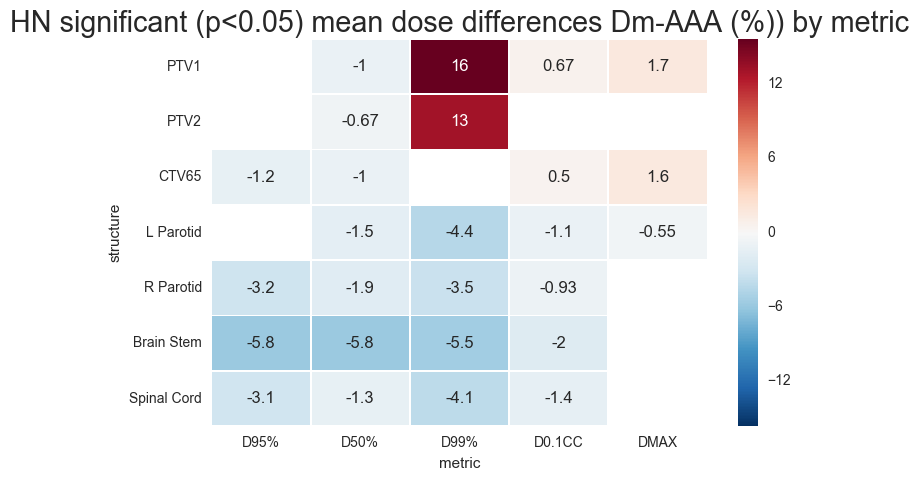

In [42]:
plt.figure(figsize=(8, 5)) 
data = percent_sub_diff_table[wilcox_data_df<0.05]

print(data.mean().mean())

mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('HN significant (p<0.05) mean dose differences Dm-AAA (%)) by metric', size='xx-large');

# Investigate differences 

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


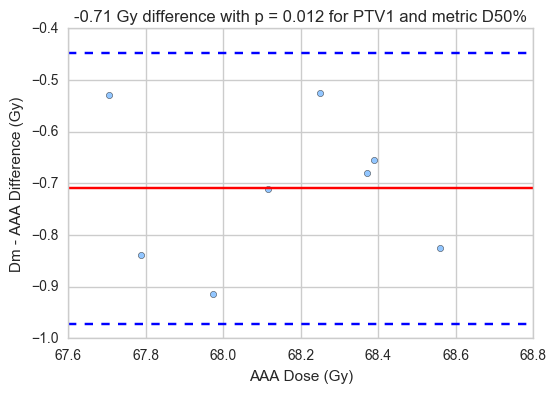

In [23]:
structure = 'PTV1'
metric = 'D50%'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
# AAA_diff_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
